In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [14]:
class nystrom_trap_single_layer:
    def __init__(self, n, a, b, lam, x1, x2, rhs):
        
        self.n = n
        self.a = a
        self.b = b
        self.lam = lam
        
        self.t = sp.Symbol('t')
        self.s = sp.Symbol('s')
        self.x1 = x1(self.s)
        self.x2 = x2(self.s)
        self.y1 = x1(self.t)
        self.y2 = x2(self.t)
        #self.x1 = x1.subs(q,self.s)
        #self.x2 = x2.subs(q,self.s)
        #self.y1 = x1.subs(q,self.t)
        #self.y2 = x2.subs(q,self.t)
        
        # initialize h for quadrature
        self.h = (b-a) / n
        
        # initialize arrays
        self.matrix = np.zeros((n,n))
        self.y_values = np.zeros(n)
        self.mu = np.zeros(n)
        
        # initialize everything else
        self.rhs = rhs.subs({q:self.y1,r:self.y2})
        self.jacobian_lam = 0
        self.dgreens_dn_lam = 0
        self.kappa_lam = 0
        
    def get_trap_weights(self,n_in):
        # weights for composite trapezoid rule, which is used to evaluate u
        weights = np.zeros(n_in + 1)
        h_in = (self.b - self.a) / n_in
        weights[0] = 0.5
        weights[n_in] = 0.5
        for i in range(1,n_in):
            weights[i] = 1
        weights = weights * h_in;
        
        return weights

    def get_t_values(self,n_in):
        # values at which a solution will be evaluated at (correspond to composite trapezoid nodes)
        t_values = np.zeros(n_in + 1)
        h_in = (self.b - self.a) / n_in
        for i in range(0,n_in+1):
            t_values[i] = self.a + i*h_in
        
        return t_values
        
    def construct_greens_function(self):
        # build all necessary functions
        # first the Jacobian
        self.jacobian = sp.sqrt(sp.Pow(sp.diff(self.y1,self.t),2) + sp.Pow(sp.diff(self.y2,self.t),2))
        self.jacobian_lam = sp.lambdify(self.t,self.jacobian)

        # normal vector in 2D
        self.normal = (1/self.jacobian) * sp.Array([-1*sp.diff(self.y2,self.t),sp.diff(self.y1,self.t)])

        # greens function and normal derivative
        self.greens_fxn = (1/(2*np.pi)) * sp.log(sp.sqrt(sp.Pow(self.x1 - self.y1,2) + sp.Pow(self.x2 - self.y2,2)))
        self.del_greens_fxn = sp.Array([-1*(1/(2*np.pi))*(1/(sp.Pow(self.x1-self.y1,2) + sp.Pow(self.x2-self.y2,2))) * (self.x1-self.y1),
                                        -1*(1/(2*np.pi))*(1/(sp.Pow(self.x1-self.y1,2) + sp.Pow(self.x2-self.y2,2))) * (self.x2-self.y2)])
        self.dgreens_dn = self.del_greens_fxn[0] * self.normal[0] + self.del_greens_fxn[1] * self.normal[1]
        self.dgreens_dn_simplified = sp.simplify(self.dgreens_dn)
        self.dgreens_dn_lam = sp.lambdify([self.t,self.s],self.dgreens_dn_simplified)
        self.greens_lam = sp.lambdify([self.t,self.s],self.greens_fxn)
        # order for inputs is (t,s)

        # for the case where the kernel is nearly singular
        self.kappa = (-1/(4*np.pi))*(sp.diff(self.y2,self.t,self.t)*sp.diff(self.y1,self.t)-sp.diff(self.y1,self.t,self.t)*sp.diff(self.y2,self.t))*(1/(sp.Pow(sp.diff(self.y1,self.t),2)+sp.Pow(sp.diff(self.y2,self.t),2)))
        self.kappa_lam = sp.lambdify(self.t,self.kappa)
            
    def build_matrix(self):
        # for loop to build matrix
        for i in range(0,self.n):
            for j in range(0,self.n): 
                if (j != i):
                    self.matrix[i,j] = self.greens_lam(self.a + self.h*j, self.a+self.h*i) * self.jacobian_lam(self.a+self.h*j)
                else:
                    self.matrix[i,j] = self.greens_lam(self.a + self.h*j, self.a+self.h*i) * self.jacobian_lam(self.a+self.h*j)
        # contruct matrix for problem of second kind
        self.matrix = self.lam * np.identity(self.n) + self.h*self.matrix
        
    def solve(self):
        # solve the linear system
        self.y_lam = sp.lambdify(self.t,self.rhs)
        for i in range(0,self.n):
            self.y_values[i] = self.y_lam(self.a + self.h*i)
        
        self.mu = np.linalg.inv(self.matrix)@self.y_values
        return self.mu
       

In [15]:
q,r = sp.symbols("q r")

# q,r are dummy variables for x1 and x2
rhs = sp.exp(q)*sp.cos(r)
N = 200
nys = nystrom_trap_single_layer(N, 0, 2*np.pi, 0, sp.cos, sp.sin, rhs)
nys.construct_greens_function()
nys.build_matrix()
mu = nys.solve()

<lambdifygenerated-16>:2: RuntimeWarning: divide by zero encountered in log
  return (0.159154943091895*log(sqrt((sin(s) - sin(t))**2 + (cos(s) - cos(t))**2)))


In [18]:
class product_trap:

    def __init__(self, n, a, b, x1, x2, rhs):
        q,r = sp.symbols("q r")
        self.n = n
        self.a = a
        self.b = b
        self.t = sp.Symbol('t')
        self.s = sp.Symbol('s')
        self.x1 = x1.subs(q,self.s)
        self.x2 = x2.subs(q,self.s)
        self.y1 = x1.subs(q,self.t)
        self.y2 = x2.subs(q,self.t)
        
        # initialize h for quadrature
        self.h = (b-a) / n
        
        # initialize arrays
        self.matrix = np.zeros((n + 1,n + 1))
        self.y_values = np.zeros(n + 1)
        self.mu = np.zeros(n + 1)
        
        # initialize everything else
        self.rhs = rhs.subs({q:self.y1,r:self.y2})
        
        
    def get_t_values(self,n_in):
        # values at which a solution will be evaluated at (correspond to quadrature nodes)
        t_values = np.zeros(n_in + 1)
        h_in = (self.b - self.a) / n_in
        for i in range(0,n_in + 1):
            t_values[i] = self.a + i*h_in

        return t_values
        
        
    def get_trap_weights(self,n_in):
        # weights for composite trapezoid rule, which is used to evaluate u
        weights = np.zeros(n_in + 1)
        h_in = (self.b - self.a) / n_in
        weights[0] = 0.5
        weights[n_in] = 0.5
        for i in range(1,n_in):
            weights[i] = 1
        weights = weights * h_in;

        return weights
        
        
    def construct_functions(self):
        # build all necessary functions
        # first the Jacobian
        self.jacobian = sp.sqrt(sp.Pow(sp.diff(self.y1,self.t),2) + sp.Pow(sp.diff(self.y2,self.t),2))
        self.jacobian_lam = sp.lambdify(self.t,self.jacobian)
            
        # smooth and singular parts of kernel
        self.L = (1/(2*np.pi))
        self.log = sp.log(sp.sqrt(sp.Pow(self.x1-self.y1,2) + sp.Pow(self.x2-self.y2,2)))
        self.log_lam = sp.lambdify([self.t,self.s],self.log)
        
        # Greens function
        self.greens_fxn = (1/(2*np.pi)) * sp.log(sp.sqrt(sp.Pow(self.x1 - self.y1,2) + sp.Pow(self.x2 - self.y2,2)))
            
        
    def build_weights(self):
        # compute weights for evenly space points
        alpha = np.zeros([self.y_values.size,self.y_values.size])
        beta = np.zeros([self.y_values.size,self.y_values.size])
        weights = np.zeros([self.y_values.size,self.y_values.size])
        
        # dummy variable for integration
        z = sp.Symbol('z')
        kvals = np.arange(-(self.n - 1),self.n + 1)
        psi = np.zeros([2,kvals.size],dtype='object')
        for i in kvals:
            psi[0,i + self.n - 1] = sp.integrate(sp.log(sp.Abs(i-z)),(z,0,1))
            psi[1,i + self.n - 1] = sp.integrate(z*sp.log(sp.Abs(i-z)),(z,0,1))
        
        for i in range(0,self.y_values.size):
            for j in range(1,self.y_values.size):
                alpha[i,j] = (self.h/2)*np.log(self.h) + self.h*(psi[0, i-j+1 + self.n - 1] - psi[1, i-j+1 + self.n - 1])
                beta[i,j] = (self.h/2)*np.log(self.h) + self.h*psi[1, i-j+1 + self.n - 1]
            
        for i in range(0,self.y_values.size):
            for j in range(0,self.y_values.size):
                if (j == 0):
                    weights[i,j] = alpha[i,1]
                elif (j == self.n):
                    weights[i,j] = beta[i,self.n]
                else:
                    weights[i,j] = beta[i,j] + alpha[i,j+1]
            
        return weights
        
    def build_linear_system(self):
        # get weights
        weights = self.build_weights()
            
        # build matrix
        for i in range(0, self.n + 1):
            for j in range(0, self.n + 1): 
                self.matrix[i,j] = weights[i,j] * self.jacobian_lam(self.a + self.h*j) * self.L
                    
                    
    def solve(self):
        self.y_lam = sp.lambdify(self.t,self.rhs)
        for i in range(0,self.n + 1):
            self.y_values[i] = self.y_lam(self.a + self.h*i)
            
        self.mu = np.linalg.inv(self.matrix)@self.y_values
            
        return self.mu
                    
                    
                    

In [19]:
q,r = sp.symbols("q r")

# q,r are dummy variables for x1 and x2
rhs = sp.exp(q)*sp.cos(r)
N = 50
a = 0
b = 2*np.pi

x1 = sp.cos(q)
x2 = sp.sin(q)

prod_trap = product_trap(N, a, b, x1, x2, rhs)
prod_trap.construct_functions()
prod_trap.build_linear_system()
mu = prod_trap.solve()

Text(0, 0.5, '$\\mu (t)$')

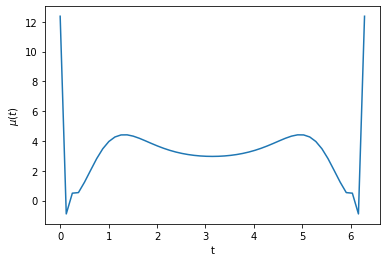

In [20]:
t_values = prod_trap.get_t_values(N)
plt.plot(t_values, mu)
plt.xlabel('t')
plt.ylabel('$\mu (t)$')

In [21]:
prod_trap.construct_functions()
greens = prod_trap.greens_fxn.subs({prod_trap.x1:q, prod_trap.x2: r})
greens = sp.simplify(greens)
greens

0.159154943091895*sqrt((q - cos(t))**2 + (r - sin(t))**2)

In [22]:
# solve for u
h = prod_trap.h
t = prod_trap.t
lam_greens = sp.lambdify(t,greens)

print(lam_greens(0))

TypeError: loop of ufunc does not support argument 0 of type Add which has no callable sqrt method

In [37]:
weights = prod_trap.get_trap_weights(N)
u = 0
for i in range(0,N+1):
        u = u + (weights[i] * mu[i] * lam_greens(h*i))

u_lam = sp.lambdify([q,r],u)
true_soln = sp.lambdify([q,r],rhs)

print(u_lam(0,0))
print(true_soln(0,0))

TypeError: loop of ufunc does not support argument 0 of type Add which has no callable log method